# Topic 10 — Rule-Based EMS (Baseline Controller)

This notebook demonstrates a transparent, heuristic Energy Management System (EMS).
It **does not** use forecasting or beliefs. We run **three independent scenarios**:

1. **Sunny Day, Grid Connected** — normal operation.
2. **Midday Islanding** — grid is disconnected for a few hours (islanded microgrid).
3. **Expensive Grid Imports** — higher grid import tariff to stress local generation & storage.

For each scenario, we build the microgrid, run the EMS-driven simulation,
and plot conference-quality figures using the project's standard utilities.


In [1]:
# --- Path setup so we can `import microgrid_sim` from the repo root
import sys, os, numpy as np, pandas as pd
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Using project_root:", project_root)

Using project_root: c:\Users\olanr\Downloads\course-proj\microgrid-control-sim


In [2]:
from microgrid_sim.core import MicrogridEnv
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.control import RuleBasedEMS, EMSRuleParams
from microgrid_sim.utils import plot_simulation

print("Imports OK")

Imports OK


Using Simulated Data

In [3]:
def build_diurnal_exogenous(steps: int, seed: int = 123,
                            pv_peak_irr=900.0, wind_mean=6.0,
                            res_base=1.5, fac_base=10.0,
                            pv_noise=0.05, wind_noise=0.10, res_noise=0.10, fac_noise=0.05):
    """
    Create a list of exogenous dicts for `steps` hours with simple diurnal patterns.
    Keys match component expectations:
        - "pv": {"irradiance_Wm2": ...}
        - "wind": {"wind_speed_ms": ...}
        - "house": {"load_kw": ...}
        - "factory": {"load_kw": ...}
    """
    rng = np.random.RandomState(seed)
    res_shape = np.array([
        0.6, 0.55, 0.5, 0.5, 0.55, 0.8, 1.0, 0.9, 0.8,
        0.7, 0.65, 0.6, 0.65, 0.8, 1.0, 1.2, 1.4, 1.2,
        1.0, 0.9, 0.8, 0.7, 0.65, 0.6
    ])
    fac_shape = np.array([
        0.2, 0.2, 0.2, 0.3, 0.5, 0.8, 1.0, 1.1, 1.1,
        1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8,
        0.6, 0.5, 0.4, 0.3, 0.2, 0.2
    ])

    exog_list = []
    for k in range(steps):
        h = k % 24
        # PV bell around noon
        pv_clear = max(0.0, np.sin((h - 6) * np.pi / 12.0))
        ghi = pv_peak_irr * pv_clear * (1.0 + pv_noise * rng.randn())

        wind = max(0.0, (wind_mean + 2.0 * np.sin(h * 2*np.pi/24 + 0.5)) * (1.0 + wind_noise * rng.randn()))
        res = max(0.0, res_base * res_shape[h] * (1.0 + res_noise * rng.randn()))
        fac = max(0.0, fac_base * fac_shape[h] * (1.0 + fac_noise * rng.randn()))

        exog_list.append({
            "pv": {"irradiance_Wm2": float(max(0.0, ghi))},
            "wind": {"wind_speed_ms": float(wind)},
            "house": {"load_kw": float(res)},
            "factory": {"load_kw": float(fac)},
        })
    return exog_list


In [4]:
def build_actions_via_ems(steps: int, env: MicrogridEnv, ems: RuleBasedEMS):
    """
    Use EMS to compute one-step actions for each hour based on current SOC and hour.
    We generate a placeholder list here, but in the main loops we apply EMS decisions
    step-by-step to account for SOC evolution.
    """
    actions_list = []
    for k in range(steps):
        hour = k % 24
        # read SOC from battery "bat" if present
        soc = 0.5
        for s in env.storage:
            if getattr(s, "name", "") == "bat":
                soc = float(s.get_soc())
        actions_list.append(ems.decide(hour=hour, soc=soc, exogenous={}))
    return actions_list

## Scenario 1 — Sunny Day, Grid Connected

,pv_power,pv_cost,wind_power,wind_cost,diesel_power,diesel_cost,grid_power,grid_cost,bat_power,bat_cost,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.483999,0.0,4.0,-1.0,0.0,-0.0,0.0,-0.0,...,4.483999,-2.745168,0.0,0.0,1.738831,0.000000,1.738831,0.0,-1.0,0.0
1,0.0,0.0,0.211664,0.0,4.0,-1.0,0.0,-0.0,0.0,-0.0,...,4.211664,-2.892826,0.0,0.0,1.318838,0.000000,1.318838,0.0,-1.0,1.0
2,0.0,0.0,1.010542,0.0,4.0,-1.0,0.0,-0.0,0.0,-0.0,...,5.010542,-2.653644,0.0,0.0,2.356898,0.000000,2.356898,0.0,-1.0,2.0
3,0.0,0.0,1.078617,0.0,4.0,-1.0,0.0,-0.0,0.0,-0.0,...,5.078617,-3.670049,0.0,0.0,1.408568,0.000000,1.408568,0.0,-1.0,3.0
4,0.0,0.0,0.870805,0.0,4.0,-1.0,0.0,-0.0,0.0,-0.0,...,4.870805,-5.974186,0.0,0.0,-1.103382,1.103382,0.000000,1.0,-1.0,4.0


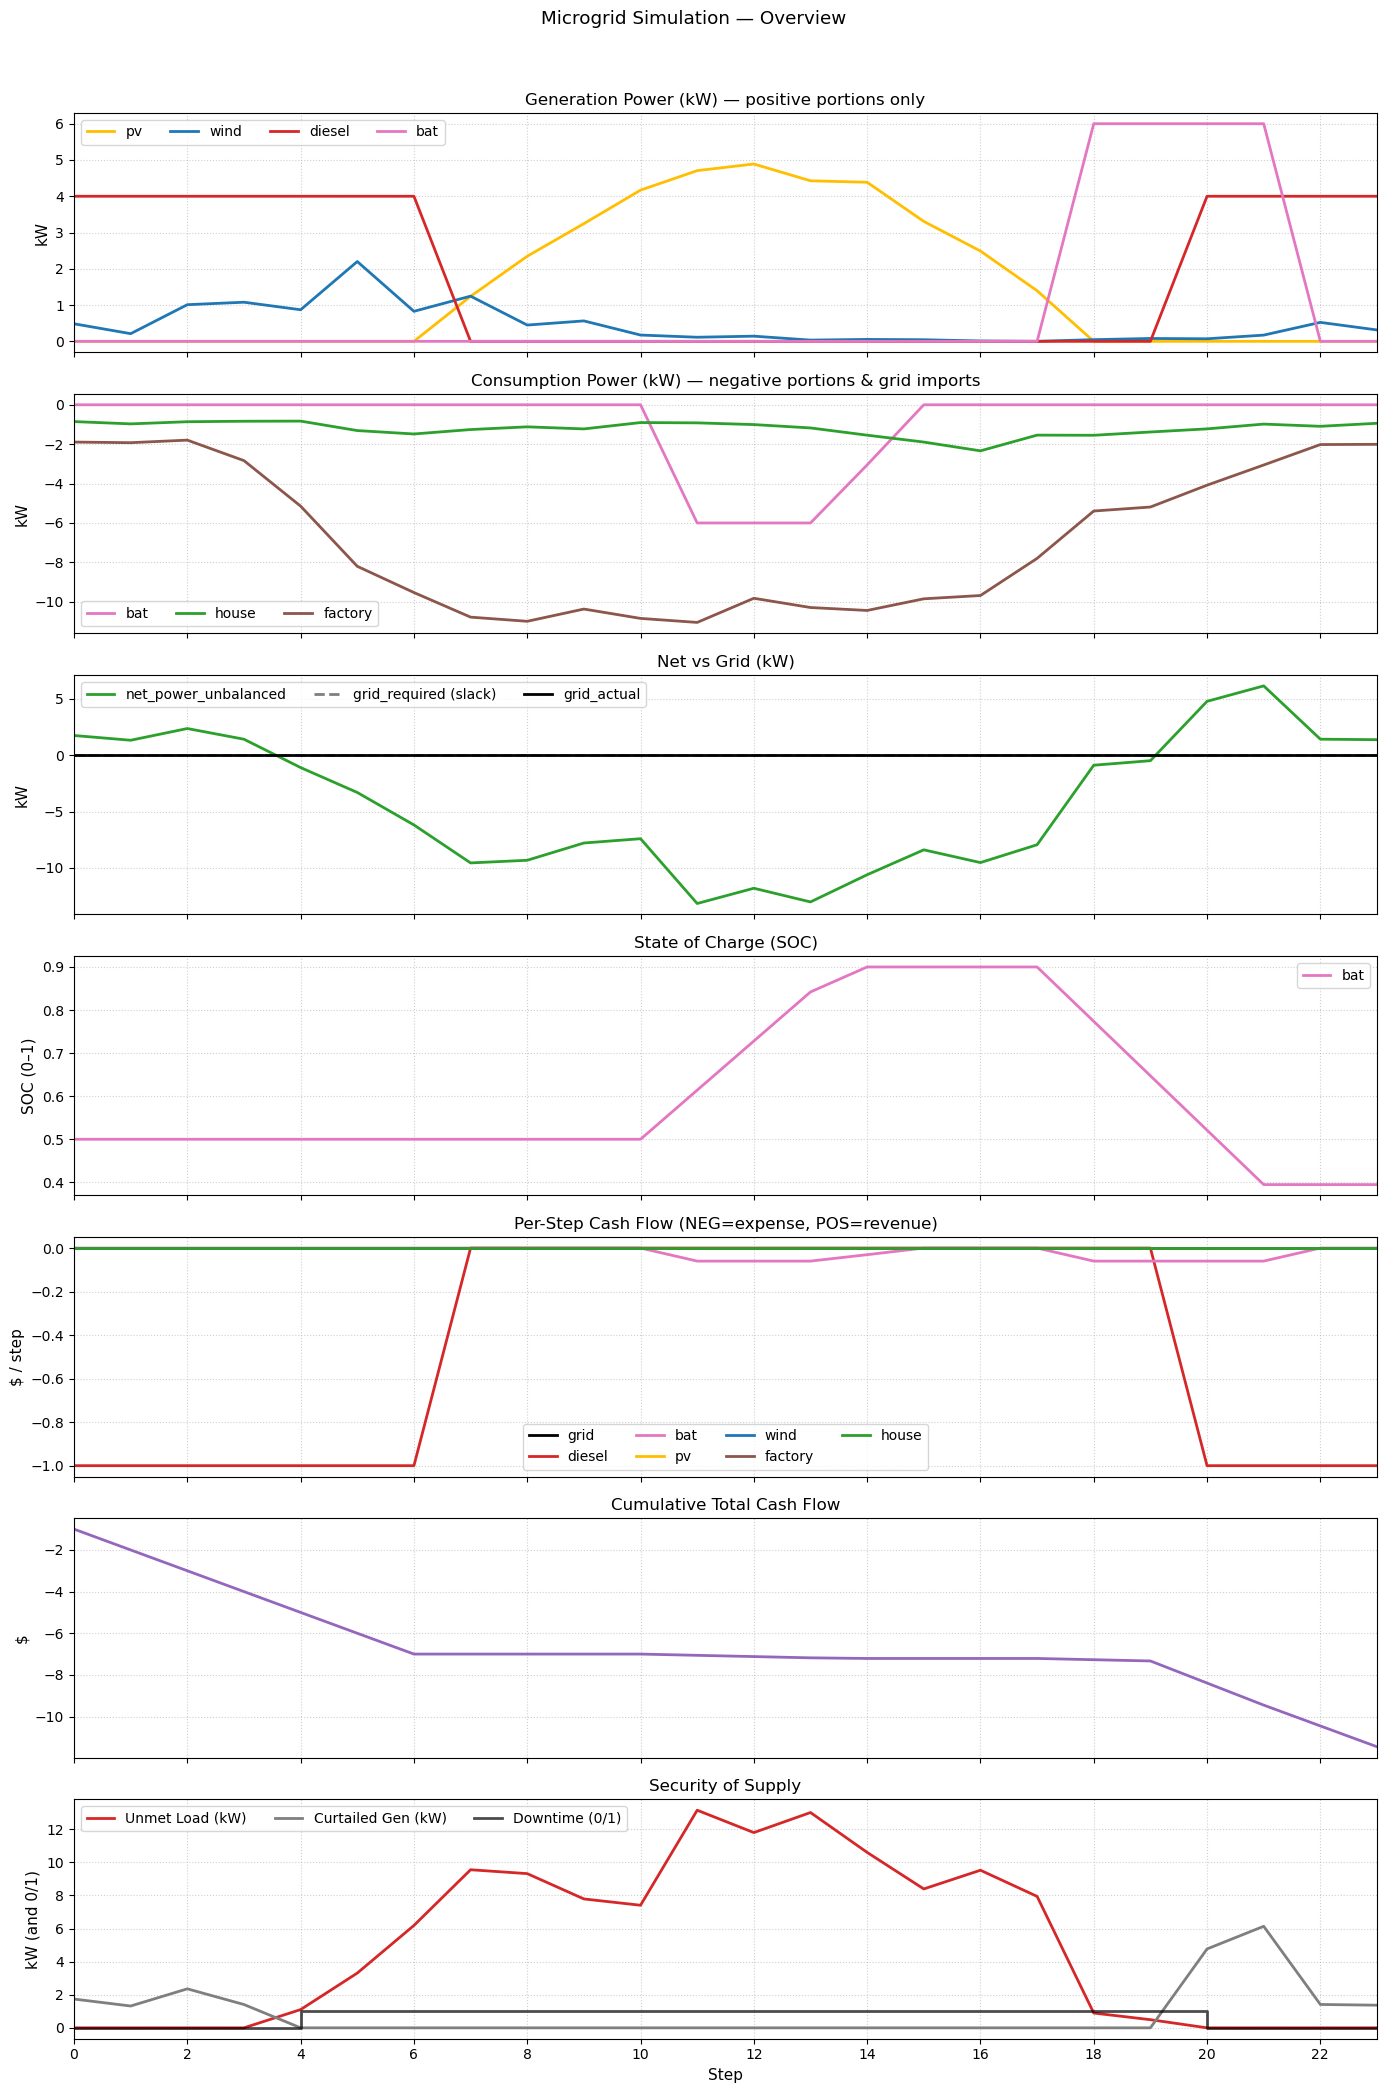

In [6]:
steps = 24 * 1
dt = 60

# Components
pv = PVGenerator("pv", capacity_kw=6.0, time_step_minutes=dt, derate=0.9)
wind = WindTurbine("wind", rated_kw=8.0, time_step_minutes=dt)
diesel = FossilGenerator("diesel", p_min_kw=0.0, p_max_kw=15.0, time_step_minutes=dt, fuel_cost_per_kwh=0.25)
house = ResidentialLoad("house", base_kw=1.5, noise_std=0.0)
factory = FactoryLoad("factory", base_kw=10.0, noise_std=0.0)
bat = BatteryStorage(
    "bat", capacity_kwh=50.0, time_step_minutes=dt, initial_soc=0.5,
    min_soc=0.1, max_soc=0.9, max_charge_kw=8.0, max_discharge_kw=8.0,
    charge_efficiency=0.95, discharge_efficiency=0.95, degradation_cost_per_kwh=0.01
)
grid = GridIntertie("grid", time_step_minutes=dt, price_import_per_kwh=0.20, price_export_per_kwh=0.05)

# Env
env = MicrogridEnv(simulation_steps=steps)
for c in (pv, wind, diesel, house, factory, bat):
    env.add_component(c)
env.add_component(grid, is_grid=True)
env.reset()

# Exogenous & EMS
exog = build_diurnal_exogenous(steps, seed=1)
ems = RuleBasedEMS()

# Online loop (step-by-step)
for k in range(steps):
    hour = k % 24
    soc = bat.get_soc()
    actions = ems.decide(hour=hour, soc=soc, exogenous=exog[k])
    env.step(actions=actions, exogenous=exog[k])

df1 = env.get_results()
_ = plot_simulation(df1, actions=None, sim_name="topic10_s1", save=True)
df1.head()
